# ResNet-18 Binary Brain Tumor Classification Model

## Project Overview
This notebook implements a binary classification model using ResNet-18 to detect the presence or absence of brain tumors in MRI images from the BRISC 2025 dataset. The model distinguishes between:
- **No Tumor** (Class 0)
- **Tumor** (Class 1) - including Glioma, Meningioma, and Pituitary tumors

---

In [1]:
!nvidia-smi

Sun Mar  1 06:22:12 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Section 1: Environment Setup

### 1.1 GPU Availability Check
Verify that a GPU is available for accelerated training.

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 Mount Google Drive
Connect to Google Drive to access stored datasets and save model weights.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("briscdataset/brisc2025")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brisc2025' dataset.
Path to dataset files: /kaggle/input/brisc2025


## Section 2: Data Loading

### 2.1 Download BRISC 2025 Dataset
Download the BRISC 2025 brain tumor MRI dataset using KaggleHub.

In [7]:
!find {path} -maxdepth 3

/kaggle/input/brisc2025
/kaggle/input/brisc2025/brisc2025
/kaggle/input/brisc2025/brisc2025/manifest.json
/kaggle/input/brisc2025/brisc2025/README.md
/kaggle/input/brisc2025/brisc2025/segmentation_task
/kaggle/input/brisc2025/brisc2025/segmentation_task/test
/kaggle/input/brisc2025/brisc2025/segmentation_task/train
/kaggle/input/brisc2025/brisc2025/classification_task
/kaggle/input/brisc2025/brisc2025/classification_task/test
/kaggle/input/brisc2025/brisc2025/classification_task/train
/kaggle/input/brisc2025/brisc2025/manifest.csv
/kaggle/input/brisc2025/brisc2025/manifest.json.sha256
/kaggle/input/brisc2025/brisc2025/manifest.csv.sha256


### 2.3 Install Dependencies
Install required libraries for deep learning and data visualization.

In [ ]:
%pip install torch torchvison sklearn seaborn matplotlib numpy PIL 

### 2.4 Import Libraries
Import all necessary Python libraries for model training and evaluation.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

import cv2

### 2.5 Configure Dataset Paths
Set up paths to the training and test directories, and define image preprocessing parameters.

In [31]:
TRAIN_DIR = path + '/brisc2025/classification_task/train'
TEST_DIR = path + '/brisc2025/classification_task/test'
input_size = 224 
reshape_size =256
#TRAIN_DIR = '/content/brisc_dataset/brisc2025/classification_task/train'
#TEST_DIR = '/content/brisc_dataset/brisc2025/classification_task/test'

In [32]:


def opencv_crop_and_clahe_loader(image_path):
    # 1. Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found. Check the path: {image_path}")

    # 2. Convert to grayscale for thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 3. Crop using contours
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_gray = gray[y:y+h, x:x+w] 
    else:
        cropped_gray = gray

    # 4. Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_applied = clahe.apply(cropped_gray)

    # 5. Convert back to 3-Channel RGB and then to PIL Image
    final_rgb_numpy = cv2.cvtColor(clahe_applied, cv2.COLOR_GRAY2RGB)
    pil_image = Image.fromarray(final_rgb_numpy)
    
    return pil_image

In [33]:
# Define how to process the images
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(p=0.5), # Flips 50% of images like a mirror
    transforms.RandomRotation(degrees=15 ),# Tilts the brain up to 15 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) 
])

# Map 'no_tumor' (index 2) to 0, and all other tumors to 1
binary_transform = lambda target: 0 if target == 2 else 1

# Load dataset (make sure this path matches how your zip file is structured inside)
dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=transform,
    target_transform=binary_transform,
    loader=opencv_crop_and_clahe_loader
)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# 1. Load the Test Data (using the same transforms as before)
test_dataset = datasets.ImageFolder(
    root = TEST_DIR,
    transform = test_transform,
    target_transform = binary_transform,
    loader = opencv_crop_and_clahe_loader
)
# shuffle=False is important here so we can match predictions to the right labels
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Section 3: Data Augmentation & Loading

### 3.1 Create DataLoaders with Augmentation
Apply transformations to images (resize, rotation, flipping) and create data loaders for training and testing. Convert multi-class labels to binary classification.

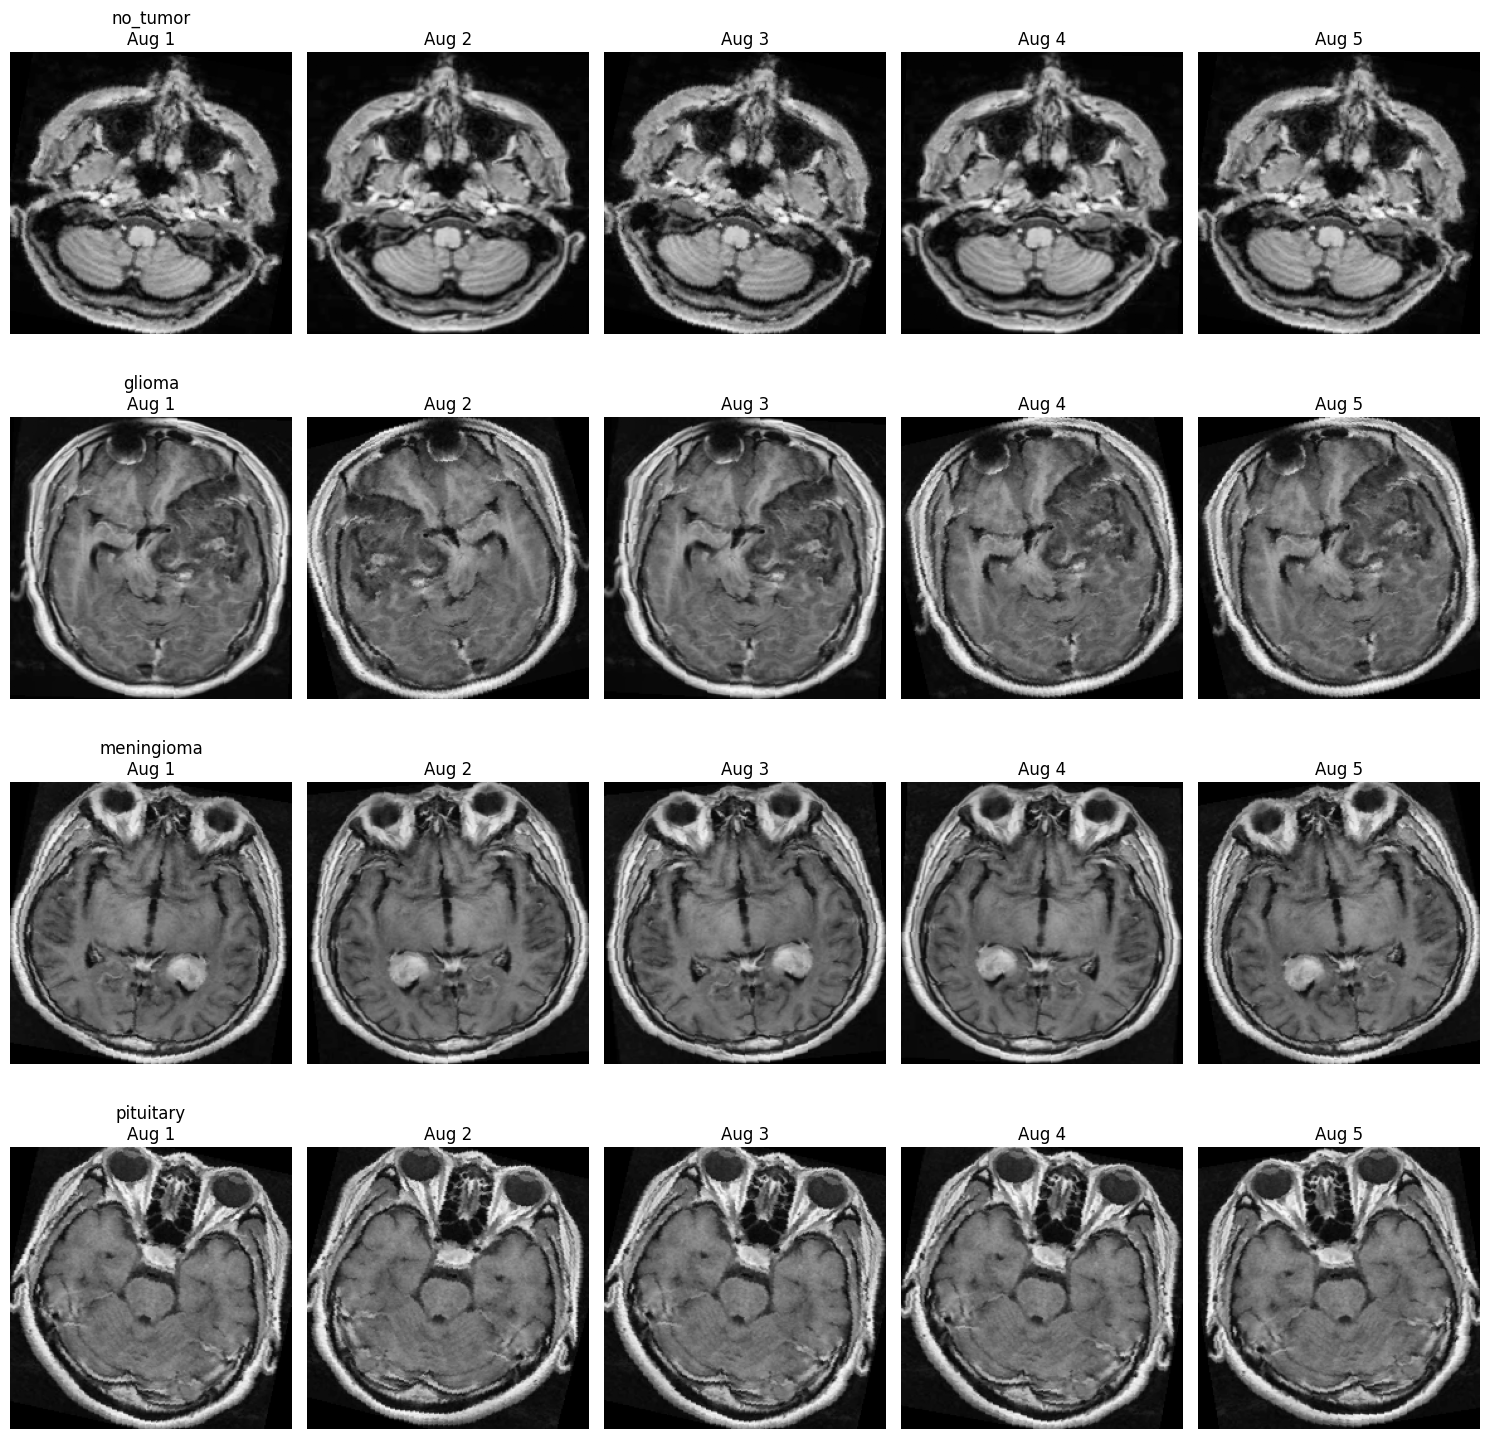

<Figure size 640x480 with 0 Axes>

In [34]:
  # Update this path to point to an actual image in your dataset
image_paths = [
             
             path+"/brisc2025/classification_task/train/no_tumor/brisc2025_train_02477_no_ax_t1.jpg",
             
             path+"/brisc2025/classification_task/train/glioma/brisc2025_train_00001_gl_ax_t1.jpg",
             
             path+"/brisc2025/classification_task/train/meningioma/brisc2025_train_01148_me_ax_t1.jpg",
             
             path+"/brisc2025/classification_task/train/pituitary/brisc2025_train_03544_pi_ax_t1.jpg",
]
vis_transform = transforms.Compose([
    transforms.Resize((224, 224)),# Add any augmentations you want to test here (e.g., RandomHorizontalFlip)
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(15),
    transforms.ToTensor() # Converts to tensor with values perfectly between 0.0 and 1.0
])

type_index = 0
fig, axes = plt.subplots(4, 5, figsize=(15, 15))

for image_path in image_paths:
    try:
        # Convert to RGB just in case your MRI is saved as a grayscale format
        cropped_and_enhanced_pil = opencv_crop_and_clahe_loader(image_path)
    except Exception as e:
        print(f"Error: loading image:{image_path} :{e}")
        continue

    # 4. Generate and plot 5 augmented versions
    for i in range(5):
        # Apply the transform to the original PIL image
        
        augmented_tensor = vis_transform(cropped_and_enhanced_pil)
        
        # Rearrange dimensions from [C, H, W] to [H, W, C] for Matplotlib
        # We also convert it to a NumPy array for plotting
        image_to_plot = augmented_tensor.permute(1, 2, 0).numpy()
        
        # Display the image
        axes[type_index][i].imshow(image_to_plot)
        axes[type_index][i].axis('off') # Hides the axis grids and numbers
        axes[type_index][i].set_title(f"Augmentation  {i+1}")

        if i == 0:
            tumor_type = image_path.split('/')[-2] # Extracts 'glioma', 'no_tumor', etc.
            axes[type_index][i].set_title(f"{tumor_type}\nAug 1")
        else:
            axes[type_index][i].set_title(f"Aug {i+1}")
    type_index += 1
# Show the final plot
plt.tight_layout()
plt.show()
plt.subplots_adjust(hspace=0.3) # Adds a little vertical breathing room
plt.show()

### 3.2 Visualize Data Augmentation
Display augmented versions of sample images from each tumor class to understand the data preprocessing.

In [35]:
# Move computations to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained ResNet18 model and change the last layer for binary output (1 node)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


## Section 4: Model Setup

### 4.1 Initialize ResNet-18 Model
Load a pre-trained ResNet-18 model, modify the final layer for binary classification, and configure loss function and optimizer.

Epoch 1/15 | Train Loss: 0.1140 | Val Loss: 0.0527 | Train Acc: 95.90% | Val Acc: 97.50%
Epoch 2/15 | Train Loss: 0.0652 | Val Loss: 0.0777 | Train Acc: 98.00% | Val Acc: 97.20%
Epoch 3/15 | Train Loss: 0.0540 | Val Loss: 0.0194 | Train Acc: 98.14% | Val Acc: 99.30%
Epoch 4/15 | Train Loss: 0.0349 | Val Loss: 0.0265 | Train Acc: 99.08% | Val Acc: 98.90%
Epoch 5/15 | Train Loss: 0.0695 | Val Loss: 0.0709 | Train Acc: 97.76% | Val Acc: 97.30%
Epoch 6/15 | Train Loss: 0.0269 | Val Loss: 0.0441 | Train Acc: 98.98% | Val Acc: 98.20%
Epoch 7/15 | Train Loss: 0.0297 | Val Loss: 0.0335 | Train Acc: 98.98% | Val Acc: 98.90%
Epoch 8/15 | Train Loss: 0.0131 | Val Loss: 0.0408 | Train Acc: 99.66% | Val Acc: 98.40%
Epoch 9/15 | Train Loss: 0.0110 | Val Loss: 0.0050 | Train Acc: 99.64% | Val Acc: 99.90%
Epoch 10/15 | Train Loss: 0.0165 | Val Loss: 0.2386 | Train Acc: 99.38% | Val Acc: 92.70%
Epoch 11/15 | Train Loss: 0.0318 | Val Loss: 0.0150 | Train Acc: 98.98% | Val Acc: 99.50%
Epoch 12/15 | Train

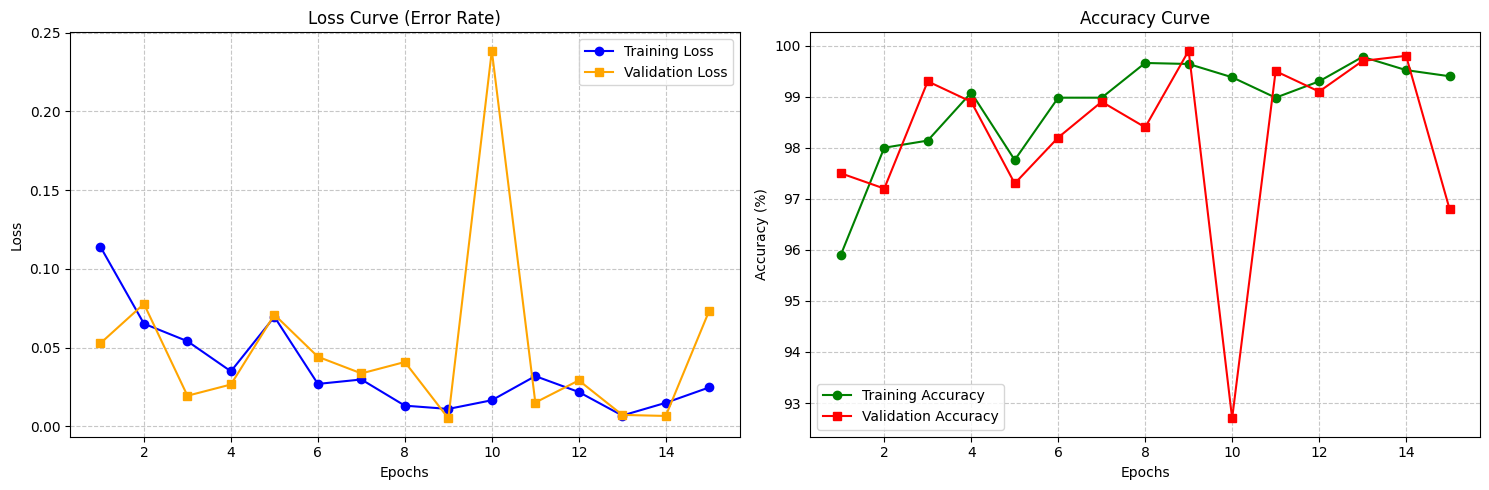

In [36]:
import matplotlib.pyplot as plt
import torch

# Lists to store metrics for our graphs
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 15

for epoch in range(epochs):
    # ==========================
    #      TRAINING PHASE
    # ==========================
    model.train()
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Accuracy math
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).float()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_acc = (train_correct / train_total) * 100

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # ==========================
    #     VALIDATION PHASE
    # ==========================
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader: # We use test_loader as our validation set
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Accuracy math
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = running_val_loss / len(test_loader)
    val_acc = (val_correct / val_total) * 100

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)



    # THE EXACT OUTPUT YOUR GUIDE WANTS
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# ==========================
#  PLOTTING THE TWO GRAPHS
# ==========================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graph 1: Loss
ax1.plot(range(1, epochs+1), train_losses, label='Training Loss', color='blue', marker='o')
ax1.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='orange', marker='s')
ax1.set_title('Loss Curve (Error Rate)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# Graph 2: Accuracy
ax2.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy', color='green', marker='o')
ax2.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='red', marker='s')
ax2.set_title('Accuracy Curve')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Section 5: Model Training

### 5.1 Train Model
Train the ResNet-18 model for 15 epochs with alternating training and validation phases. Track loss and accuracy metrics.

In [37]:


# 2. Run the Evaluation Loop
model.eval() # Put the model in evaluation mode (turns off dropout, etc.)
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad(): # Turn off gradient tracking to save memory and compute
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)    # Convert raw logits to probabilities (0.0 to 1.0)
        preds = (probs >= 0.3).float()    # Threshold at 0.5 to decide Tumor (1) or No Tumor (0)

        # Save batches to our master lists
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Calculate Core Metrics
accuracy = accuracy_score(all_labels, all_preds)
sensitivity = recall_score(all_labels, all_preds) # In medicine, Recall is called Sensitivity
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

# 4. Extract Specificity from the Confusion Matrix
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

# 5. Print the Results
print(f"Accuracy:    {accuracy * 100:.2f}%")
print(f"Sensitivity: {sensitivity * 100:.2f}%")
print(f"Specificity: {specificity * 100:.2f}%")
print(f"F1-Score:    {f1:.4f}")
print(f"AUC-ROC:     {auc:.4f}")

Accuracy:    98.00%
Sensitivity: 97.67%
Specificity: 100.00%
F1-Score:    0.9882
AUC-ROC:     0.9997


## Section 6: Model Evaluation & Performance Metrics

### 6.1 Calculate Evaluation Metrics
Generate predictions on the test set and calculate important medical performance metrics:
- **Accuracy**: Overall correctness of the model
- **Sensitivity (Recall)**: True positive rate - ability to detect tumors
- **Specificity**: True negative rate - ability to correctly identify no-tumor cases
- **F1-Score**: Harmonic mean of precision and recall
- **AUC-ROC**: Area under the receiver operating characteristic curve

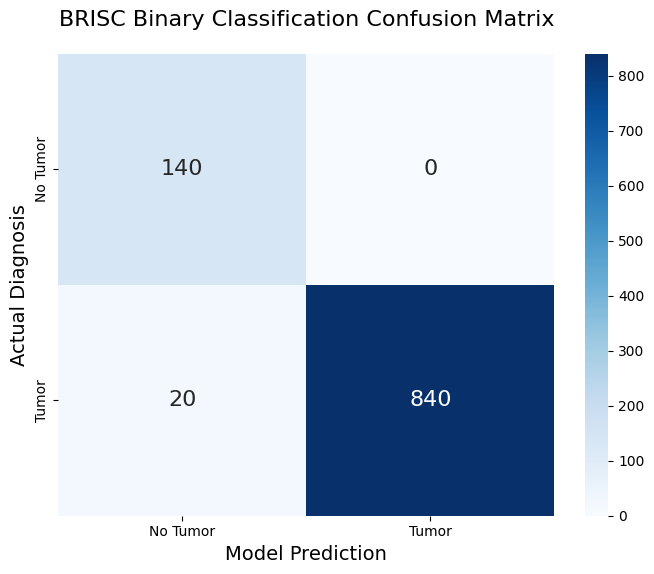

In [38]:

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Set up the visual plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'],
            annot_kws={"size": 16}) # Makes the numbers larger

# Add labels and a title
plt.ylabel('Actual Diagnosis', fontsize=14)
plt.xlabel('Model Prediction', fontsize=14)
plt.title('BRISC Binary Classification Confusion Matrix', fontsize=16, pad=20)
plt.show()

### 6.2 Visualize Confusion Matrix
Display a heatmap of the confusion matrix showing true positives, false positives, true negatives, and false negatives.

In [39]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Mini Project Sem-6(Brain Tumor Classification)/Models/preprocessed_resnet18_binary_model.pth")

## Section 7: Model Persistence

### 7.1 Save Trained Model
Save the trained model weights to Google Drive for future use and deployment.